In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
%matplotlib inline

In [2]:
df = pd.read_csv("df_with_gcs.txt",sep=',',header=0)

In [3]:
#划分训练测试集
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.1, random_state=42)

处理词向量

In [4]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

In [5]:
# 切分词汇
def cut(data):
    cut= [s.split() for s in data['TriageNote'].astype(str)]
    return cut

In [6]:
train_text=cut(train_set)
test_text=cut(test_set)
sentences=train_text+test_text

In [7]:
#得到最大句子长度
num_list=[len(one) for one in sentences]
max(num_list)

57

In [8]:
maxLen=64

In [9]:
#处理label->one_hot
from sklearn.preprocessing import LabelEncoder

def encodelabel(data):
    le = LabelEncoder()
    resultLable=le.fit_transform(data['DISPOSITION'])
    return resultLable


In [10]:
train_lable=encodelabel(train_set)
test_lable=encodelabel(test_set)

In [11]:
wvmodel = word2vec.Word2Vec.load("./word2vec_all.model")

2022-11-09 17:25:25,280 : INFO : loading Word2Vec object from ./word2vec_all.model
2022-11-09 17:25:25,289 : INFO : loading wv recursively from ./word2vec_all.model.wv.* with mmap=None
2022-11-09 17:25:25,289 : INFO : setting ignored attribute cum_table to None
2022-11-09 17:25:25,357 : INFO : Word2Vec lifecycle event {'fname': './word2vec_all.model', 'datetime': '2022-11-09T17:25:25.357025', 'gensim': '4.2.0', 'python': '3.10.6 | packaged by conda-forge | (main, Oct 24 2022, 16:02:16) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


In [13]:
nekg=np.load('./1-999 100d step 1/conkb 0-999 100d.npy')

In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab = tokenizer.word_index 

In [15]:
#特征数字编号，不足的话会在前面补充0
trainID = tokenizer.texts_to_sequences(train_text)
# print(trainID)
testID = tokenizer.texts_to_sequences(test_text)
trainSeq=pad_sequences(trainID,maxlen=maxLen)
#print(trainSeq)
testSeq=pad_sequences(testID,maxlen=maxLen)

#标签的独热编码
trainCate = to_categorical(train_lable, num_classes=2)  # 将标签转换为one-hot编码
#print(trainCate)
testCate= to_categorical(test_lable, num_classes=2)  # 将标签转换为one-hot编码

In [16]:
def nekg_embed(n0):
    n1=int(n0)
    n2=int(n0)+1
    s1=(n2-n0)/(n2-n1)
    s2=(n0-n1)/(n2-n1)
    return s1*nekg[n1]+s2*nekg[n2]

embedding_matrix = np.zeros((len(vocab) + 1, 100))
for word, i in vocab.items():
    try:
        embedding_vector = wvmodel.wv[str(word)]
        embedding_matrix[i] = embedding_vector    
    except KeyError:
        continue

In [17]:
#利用训练后的word2vec自定义Embedding的训练矩阵，每行代表一个词（结合独热码和矩阵乘法理解）
embedding_matrix = np.zeros((len(vocab) + 1, 100))
for word, i in vocab.items():
    try:
        if(word.isdigit()==False):#对word用word2vec
            embedding_vector = wvmodel.wv[str(word)]
        else:#对number用nekg
            if (int(float(word))<=999):
                embedding_vector =  nekg_embed(float(word))
            else:
                embedding_vector = wvmodel.wv[str(word)]
        embedding_matrix[i] = embedding_vector    
    except KeyError:
        continue

In [18]:
## 定义LSTM模型
batch_size=8
inputs = Input(name='inputs',shape=[maxLen])
embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
model=Sequential()
model.add(embedder)
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(Dense(64,activation="softmax",name="FC1"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax",name="FC2"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
history=model.fit(trainSeq, trainCate, batch_size, epochs=15,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])
model.save("LSTM")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           806300    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 852,830
Trainable params: 852,830
Non-trai

2022-11-09 17:25:59,332 : WARNING : Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: LSTM\assets


2022-11-09 17:25:59,698 : INFO : Assets written to: LSTM\assets


In [19]:
#预测与评估
mainModel = load_model('LSTM')
result = mainModel.predict(testSeq)  # 预测样本属于每个类别的概率
score = mainModel.evaluate(testSeq,
                           testCate,
                           batch_size=32)
print(score)

6/6 [==============================] - 0s 6ms/step - loss: 0.5762 - accuracy: 0.7076
[0.576190173625946, 0.707602322101593]


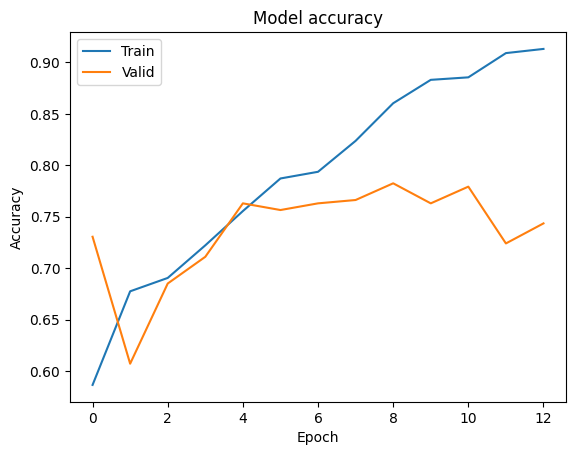

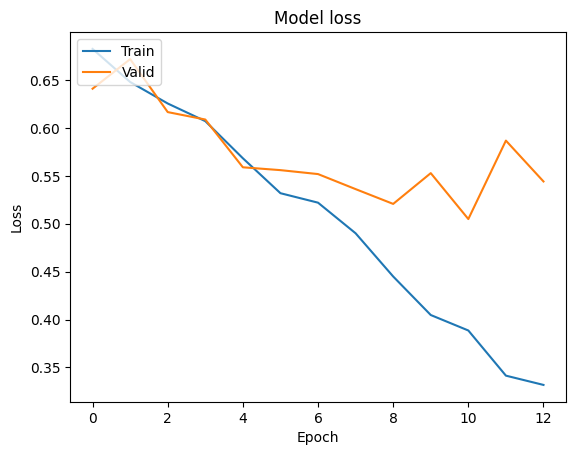

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Valid'],loc='upper left')
plt.show()

In [21]:
score_list=[]
for i in range(10):
    ## 定义LSTM模型
    batch_size=8
    inputs = Input(name='inputs',shape=[maxLen])
    embedder = Embedding(len(vocab) + 1, 100, input_length=maxLen, weights=[embedding_matrix], trainable=True)
    model=Sequential()
    model.add(embedder)
    model.add(LSTM(64))
    model.add(Dropout(0.4,seed=12))
    model.add(Dense(64,activation="softmax",name="FC1"))
    model.add(Dropout(0.4,seed=12))
    model.add(Dense(2,activation="softmax",name="FC2"))
    model.summary()
    model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1 ,patience=3, mode='auto')
    history=model.fit(trainSeq, trainCate, batch_size, epochs=15,validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2)])
    result = model.predict(testSeq)  # 预测样本属于每个类别的概率
    score = model.evaluate(testSeq,
                               testCate,
                               batch_size=32)
    score_list.append(score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           806300    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 FC2 (Dense)                 (None, 2)                 130       
                                                                 
Total params: 852,830
Trainable params: 852,830
Non-tr

Epoch 6/15
154/154 [==============================] - 2s 10ms/step - loss: 0.5297 - accuracy: 0.7904 - val_loss: 0.5767 - val_accuracy: 0.7208
Epoch 7/15
6/6 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6608
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 64, 100)           806300    
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 FC1 (Dense)                 (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
             

Epoch 1/15
154/154 [==============================] - 3s 12ms/step - loss: 0.6836 - accuracy: 0.5776 - val_loss: 0.6907 - val_accuracy: 0.5292
Epoch 2/15
154/154 [==============================] - 2s 10ms/step - loss: 0.6358 - accuracy: 0.6946 - val_loss: 0.6386 - val_accuracy: 0.6721
Epoch 3/15
154/154 [==============================] - 2s 10ms/step - loss: 0.6294 - accuracy: 0.6832 - val_loss: 0.6202 - val_accuracy: 0.6948
Epoch 4/15
154/154 [==============================] - 2s 10ms/step - loss: 0.6103 - accuracy: 0.7157 - val_loss: 0.5893 - val_accuracy: 0.7240
Epoch 5/15
154/154 [==============================] - 2s 10ms/step - loss: 0.5824 - accuracy: 0.7392 - val_loss: 0.5792 - val_accuracy: 0.7468
Epoch 6/15
154/154 [==============================] - 2s 10ms/step - loss: 0.5742 - accuracy: 0.7474 - val_loss: 0.5903 - val_accuracy: 0.7208
Epoch 7/15
154/154 [==============================] - 2s 10ms/step - loss: 0.5213 - accuracy: 0.7855 - val_loss: 0.5620 - val_accuracy: 0.7403

Epoch 5/15
154/154 [==============================] - 2s 11ms/step - loss: 0.5421 - accuracy: 0.7799 - val_loss: 0.5788 - val_accuracy: 0.7273
Epoch 6/15
154/154 [==============================] - 2s 11ms/step - loss: 0.5136 - accuracy: 0.8115 - val_loss: 0.5584 - val_accuracy: 0.7565
Epoch 7/15
154/154 [==============================] - 2s 11ms/step - loss: 0.4743 - accuracy: 0.8245 - val_loss: 0.5310 - val_accuracy: 0.7760
Epoch 8/15
154/154 [==============================] - 2s 11ms/step - loss: 0.4227 - accuracy: 0.8595 - val_loss: 0.5524 - val_accuracy: 0.7435
Epoch 9/15
6/6 [==============================] - 0s 9ms/step - loss: 0.5697 - accuracy: 0.7310
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 64, 100)           806300    
                                                                 
 lstm_10 (LSTM)              (None, 64)      

In [22]:
print('accuracy:'+str(sum(score_list)/len(score_list)))

accuracy:0.7005847990512848


In [23]:
score_list.sort()

In [24]:
score_list

[0.6608186960220337,
 0.6666666865348816,
 0.6900584697723389,
 0.6959064602851868,
 0.7017543911933899,
 0.7017543911933899,
 0.7134503126144409,
 0.719298243522644,
 0.7251461744308472,
 0.7309941649436951]

In [125]:
sum(score_list[2:])/8

0.7141812890768051